In [75]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [76]:
class AntColonyOptimizer:

    def __init__(self, edge_list, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0,
                 beta_evaporation_rate=0, choose_best=0.1, tmax=100):
        self.edge_list = edge_list
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.intensification = intensification
        self.alpha = alpha
        self.beta = beta
        self.beta_evaporation_rate = beta_evaporation_rate
        self.choose_best = choose_best
        self.tmax = tmax

        self.vmap, self.int_edge_list = self._map_to_int(edge_list)

        self.graph = nx.Graph()
        self.graph.add_edges_from(self.int_edge_list)

        self.adj_matrix = nx.adjacency_matrix(self.graph).todense()
        self.n = self.adj_matrix.shape[0]

        # self.pheromone_matrix = self.adj_matrix.A1.reshape(self.n, self.n).astype(float)
        self.pheromone_matrix = np.ones((self.n, self.n))
        self.pheromone_matrix[np.eye(self.n) == 1] = 0
        # self.heuristic_matrix = self.pheromone_matrix #  TODO add weights to heuristic matrix

        neighbors = []
        for i in range(self.n):
            neighbors.append(len([x for x in nx.neighbors(self.graph, i)]))

        self.heuristic_matrix = np.array(neighbors)
        self.heuristic_matrix = np.tile(self.heuristic_matrix, self.n)
        self.heuristic_matrix = self.heuristic_matrix.reshape(self.n, self.n)
        self.heuristic_matrix[np.eye(self.n) == 1] = 0

        self.prob_matrix = None
        self._update_probabilities()

        self.best_series = []
        self.best_solution = None
        self.best_score = self.n + 1

    def _map_to_int(self, edges):
        i = 0
        vmap = {}
        int_edge_list = []
        for e in edges:
            if e[0] not in vmap:
                vmap[e[0]] = i
                vmap[i] = e[0]
                i += 1
            if e[1] not in vmap:
                vmap[e[1]] = i
                vmap[i] = e[1]
                i += 1
            int_edge_list.append((vmap[e[0]], vmap[e[1]]))
        return vmap, int_edge_list

    def _update_probabilities(self):
        self.prob_matrix = (self.pheromone_matrix ** self.alpha) * (self.heuristic_matrix ** self.beta)

    def _chose_next_node(self, curr_node, available_nodes):
        numerator = self.prob_matrix[curr_node, available_nodes]
        denominator = np.sum(numerator)
        probabilities = numerator / denominator
        return np.random.choice(range(len(probabilities)), p=probabilities)

    def _is_valid_solution(self, solution):
        x = [edge for edge in self.int_edge_list if edge[0] in solution or edge[1] in solution]
        return len(x) == len(self.int_edge_list)

    def _evaluate(self, solutions):
        x_coords = None
        y_coords = None
        best_solution = None
        best_score = self.n + 1
        for s in solutions:
            if len(s) < best_score:
                best_score = len(s)
                best_solution = s
                x_coords = []
                y_coords = []
                for i in range(len(s) - 1):
                    x_coords.append(s[i])
                    y_coords.append(s[i + 1])

        return (x_coords, y_coords), best_solution, best_score

    def _evaporation(self):
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        self.beta *= (1 - self.beta_evaporation_rate)

    def _intensify(self, coords):
        x = coords[0]
        y = coords[1]
        self.pheromone_matrix[x, y] += self.intensification

    def fit(self):
        for t in range(self.tmax):
            solutions = []
            for ant in range(self.ants):
                solution = []
                available_nodes = list(range(self.n))
                curr_node = available_nodes[np.random.randint(0, len(available_nodes))]

                while True:
                    solution.append(curr_node)
                    available_nodes.remove(curr_node)
                    if self._is_valid_solution(solution):
                        break
                    else:
                        curr_node_idx = self._chose_next_node(curr_node, available_nodes)
                        curr_node = available_nodes[curr_node_idx]

                solutions.append(solution)

            best_solution_coords, best_solution, best_score = self._evaluate(solutions)

            if best_score < self.best_score:
                self.best_score = best_score
                self.best_solution = best_solution

            self.best_series.append(best_score)

            self._evaporation()
            self._intensify(best_solution_coords)
            self._update_probabilities()

            print(f'Iteration {t + 1}/{self.tmax}: Best Score = {best_score}, Global Best Score = {self.best_score}')

        print(f'Best fit: Score = {self.best_score}, Solution = {[self.vmap[i] for i in self.best_solution]}')
        plt.figure(figsize=(18, 12))
        plt.plot(self.best_series)
        plt.show()

        color_map = []
        labels = {}
        for i in range(self.n):
            if i in self.best_solution:
                color_map.append('red')
            else:
                color_map.append('blue')
            labels[i] = self.vmap[i]

        nx.draw(self.graph, labels=labels, node_color=color_map)


C:\Users\Johann\AppData\Local\Temp\ipykernel_16104\3895657336.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj_matrix = nx.adjacency_matrix(self.graph).todense()


Iteration 1/100: Best Score = 7, Global Best Score = 7
Iteration 2/100: Best Score = 8, Global Best Score = 7
Iteration 3/100: Best Score = 9, Global Best Score = 7
Iteration 4/100: Best Score = 8, Global Best Score = 7
Iteration 5/100: Best Score = 9, Global Best Score = 7
Iteration 6/100: Best Score = 7, Global Best Score = 7
Iteration 7/100: Best Score = 7, Global Best Score = 7
Iteration 8/100: Best Score = 7, Global Best Score = 7
Iteration 9/100: Best Score = 8, Global Best Score = 7
Iteration 10/100: Best Score = 7, Global Best Score = 7
Iteration 11/100: Best Score = 7, Global Best Score = 7
Iteration 12/100: Best Score = 7, Global Best Score = 7
Iteration 13/100: Best Score = 8, Global Best Score = 7
Iteration 14/100: Best Score = 7, Global Best Score = 7
Iteration 15/100: Best Score = 7, Global Best Score = 7
Iteration 16/100: Best Score = 7, Global Best Score = 7
Iteration 17/100: Best Score = 7, Global Best Score = 7
Iteration 18/100: Best Score = 7, Global Best Score = 7
I

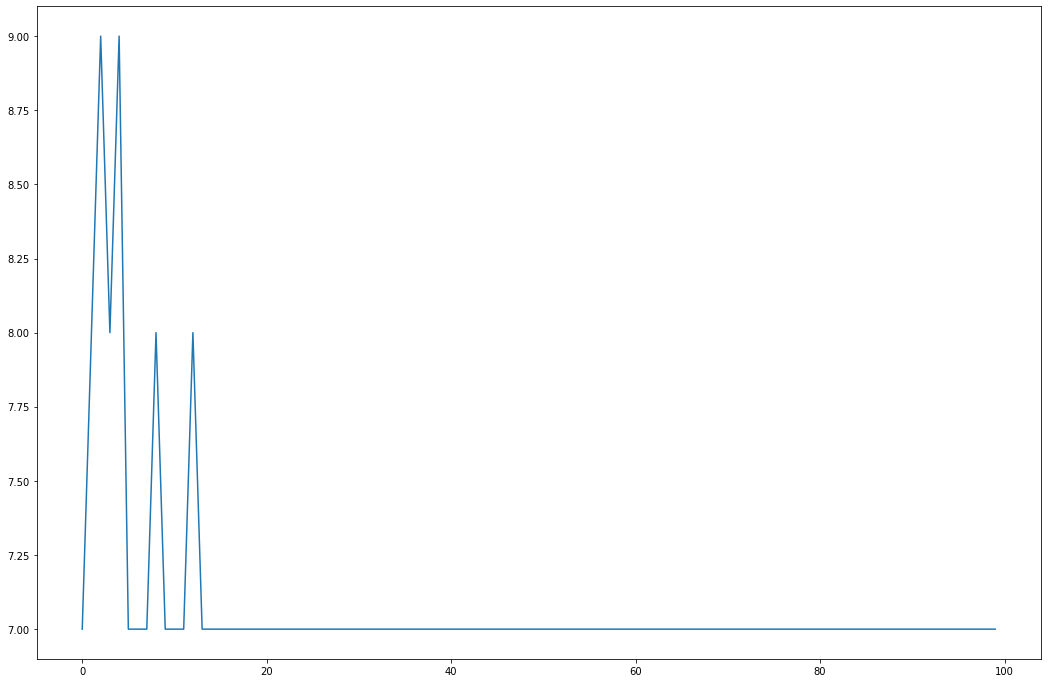

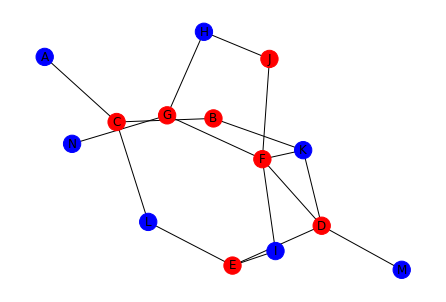

In [77]:
edges = [("A", "C"), ("C", "B"), ("B", "K"), ("C", "L"),
         ("K", "D"), ("D", "F"), ("D", "M"), ("D", "E"),
         ("E", "L"), ("E", "I"), ("I", "F"), ("F", "G"),
         ("G", "H"), ("G", "N"), ("H", "J"), ("F", "J"),
         ("K", "F")]

aco = AntColonyOptimizer(edges, ants=10, evaporation_rate=0.2, intensification=0.4, alpha=1, beta=1, tmax=100)
aco.fit()
# print('c')